#### Data preparation: movie_lines.txt and movie_conversations.txt

In [22]:
import collections
import pandas as pd
import torch
from itertools import zip_longest

### construct a vocab

In [23]:
# 预定义的token
PAD_token = 0  # 表示padding 
SOS_token = 1  # 句子的开始 
EOS_token = 2  # 句子的结束 

class vocab:
    def __init__(self):
        self.index2word = {PAD_token:'PAD',SOS_token:'SOS',EOS_token:'EOS'}
        self.word2index = collections.defaultdict(int)
        self.word2count = collections.defaultdict(int)
        self.word_num = 3
    def addWords(self,word):
        if word not in self.word2index:
            self.word_num += 1
            self.word2index[word] = self.word_num
            self.index2word[self.word_num] = word
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
            
    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWords(word)
        

### read the conversation data

In [24]:
df = pd.read_csv('pairs.csv')
pairs = []
for i,j in zip(df['0'],df['1']):
    pairs.append([str(i).strip(),str(j).strip()])

In [25]:
pairs = sorted(pairs, key = len)
pairs

[['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .'],
 ['then that s all you had to say .', 'but'],
 ['but', 'you always been this selfish ?'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['what good stuff ?', 'the real you .'],
 ['wow', 'let s go .'],
 ['she okay ?', 'i hope so .'],
 ['they do to !', 'they do not !'],
 ['did you change your hair ?', 'no .'],
 ['no .', 'you might wanna think about it'],
 ['who ?', 'joey .'],
 ['great', 'would you mind getting me a drink cameron ?'],
 ['it s more', 'expensive ?'],
 ['where ve you been ?', 'nowhere . . . hi daddy .'],
 ['what ?', 'in th . for a month'],
 ['in th . for a month', 'why ?'],
 ['why ?', 'he was like a total babe'],
 ['he was like a total babe', 'but you hate joey'],
 ['you looked beautiful last night you know .', 'so did you'],
 ['let go !', 'you 

In [26]:
vocab = vocab()
def addVocab(pairs, vocab):
    for sents in pairs:
        for sent in sents:
            vocab.addSentence(sent)

#### add all sentences to the vocab 7735 words in total

In [27]:
addVocab(pairs, vocab)
vocab.word_num

7735

#### change the sentence to index

In [28]:
def sent2index(sent, vocab):
    return [vocab.word2index[word] for word in sent.split()]

def padSent(sents, fillvalue=PAD_token):
    return list(zip_longest(*sents, fillvalue=fillvalue)) 

#### test the sent2index and padSent function

In [29]:
sent =['you have my word . as a gentleman', 'you re sweet .','what good stuff ?', 'the real you .','no .', 'you might wanna think about it']
print(sent2index(sent[0],vocab),sent2index(sent[1], vocab))

[8, 9, 10, 11, 5, 12, 13, 14] [8, 15, 16, 5]


#### after padding with 0

In [30]:
sents = []
for s in sent:
    sents.append(sent2index(s,vocab))
padSent(sents)

[(8, 8, 44, 47, 28, 8),
 (9, 15, 45, 48, 5, 64),
 (10, 16, 46, 8, 0, 65),
 (11, 5, 7, 5, 0, 66),
 (5, 0, 0, 0, 0, 67),
 (12, 0, 0, 0, 0, 68),
 (13, 0, 0, 0, 0, 0),
 (14, 0, 0, 0, 0, 0)]

#### convert a sentence to a tensor

In [31]:
def inputVar(sents, vocab):
    l_batch = [sent2index(sent,vocab) for sent in sents]
    lens = torch.tensor([len(l) for l in l_batch])
    pad_batch = torch.LongTensor(padSent(l_batch))
    return pad_batch, lens

In [32]:
inputVar(sent, vocab)

(tensor([[ 8,  8, 44, 47, 28,  8],
         [ 9, 15, 45, 48,  5, 64],
         [10, 16, 46,  8,  0, 65],
         [11,  5,  7,  5,  0, 66],
         [ 5,  0,  0,  0,  0, 67],
         [12,  0,  0,  0,  0, 68],
         [13,  0,  0,  0,  0,  0],
         [14,  0,  0,  0,  0,  0]]), tensor([8, 4, 4, 4, 2, 6]))

#### generate a binary matrix when has value 

In [33]:
def binaryMatrix(sents, vocab):
    l_batch = [sent2index(sent,vocab) for sent in sents]
    matrix = padSent(l_batch)
    binary = []
    for l in matrix:
        binary.append([1 if i else 0 for i in l])
    return binary
binaryMatrix(sent, vocab)

[[1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 0, 1],
 [1, 1, 1, 1, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0]]

#### generate the output tensor and the mask for loss function later

In [34]:
def outputVar(sents, vocab):
    l_batch = [sent2index(sent,vocab) for sent in sents]
    max_lens = max([len(l) for l in l_batch])
    pad_batch = torch.LongTensor(padSent(l_batch))
    mask = binaryMatrix(sents, vocab)
    mask = torch.ByteTensor(mask)
    return pad_batch, mask, max_lens
outputVar(sent, vocab)

(tensor([[ 8,  8, 44, 47, 28,  8],
         [ 9, 15, 45, 48,  5, 64],
         [10, 16, 46,  8,  0, 65],
         [11,  5,  7,  5,  0, 66],
         [ 5,  0,  0,  0,  0, 67],
         [12,  0,  0,  0,  0, 68],
         [13,  0,  0,  0,  0,  0],
         [14,  0,  0,  0,  0,  0]]), tensor([[1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 0, 1],
         [1, 1, 1, 1, 0, 1],
         [1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0]], dtype=torch.uint8), 8)

#### pairs processing 

In [35]:
def BatchTrainPairs(PairsBatch,vocab):
    PairsBatch = sorted(PairsBatch, key=lambda x: len(x[0].split()),reverse=True)
    InputSent, OutputSent = [], []
    for i,j in PairsBatch:
        InputSent.append(i)
        OutputSent.append(j)
    InputBatch, lens = inputVar(InputSent, vocab)
    OutputBatch, mask, MaxLen = outputVar(OutputSent, vocab)
    return InputBatch, lens,OutputBatch, mask, MaxLen

In [36]:
PairsBatch = [['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .']]
BatchTrainPairs(PairsBatch, vocab)

(tensor([[ 8, 27,  9,  4, 17],
         [ 9, 28, 25,  5,  5],
         [10,  5, 23,  0,  0],
         [11,  5,  7,  0,  0],
         [ 5,  5,  0,  0,  0],
         [12,  0,  0,  0,  0],
         [13,  0,  0,  0,  0],
         [14,  0,  0,  0,  0]]),
 tensor([8, 5, 4, 2, 2]),
 tensor([[ 8, 29, 26,  6, 18],
         [15, 30,  0,  7, 19],
         [16, 31,  0,  0, 20],
         [ 5, 32,  0,  0, 21],
         [ 0,  8,  0,  0, 22],
         [ 0, 33,  0,  0, 23],
         [ 0, 34,  0,  0, 24],
         [ 0, 35,  0,  0,  7],
         [ 0,  5,  0,  0,  0]]),
 tensor([[1, 1, 1, 1, 1],
         [1, 1, 0, 1, 1],
         [1, 1, 0, 0, 1],
         [1, 1, 0, 0, 1],
         [0, 1, 0, 0, 1],
         [0, 1, 0, 0, 1],
         [0, 1, 0, 0, 1],
         [0, 1, 0, 0, 1],
         [0, 1, 0, 0, 0]], dtype=torch.uint8),
 9)

### begin the seq2seq model after data preparation 

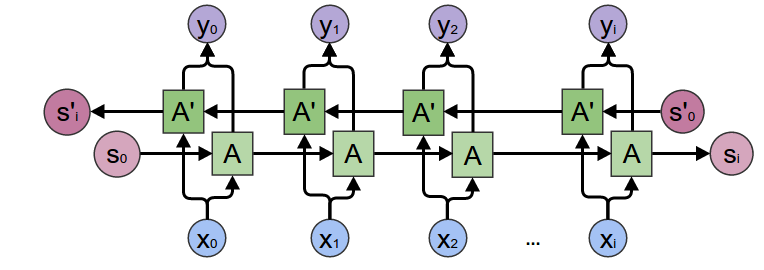

In [37]:
from IPython.display import display, Image
Image( filename =  'RNN-bidirectional.png' )

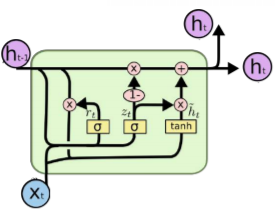

In [38]:
Image( filename =  'gru.jpg' )

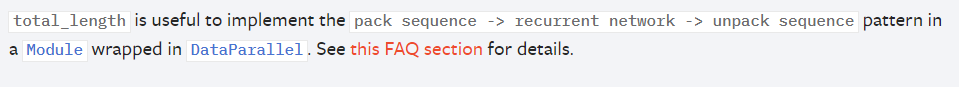

In [39]:
Image( filename = 'packed_gru.jpg')

### Encoder Layer

In [19]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, embedding, num_layers=1, dropout=0):
        super(EncoderLayer, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, dropout=dropout, bidirectional=True)
    
    def forward(self, input_seq, input_lens, hidden):
        embedded = self.embedding(input_seq)
        
        # 做pack_padded_sequence的固定格式
        packed = pack_padded_sequence(embedded, input_lens)
        outputs, hidden = self.gru(packed, hidden)
        outputs, _ = pack_padded_sequence(output)
        
        #bidirectional gru, 前面那个是forward时候的output, 后面那个是backward的output，所以最后的output是两者相加
        outputs = outputs[:,:,:self.hidden_size] + outputs[:,:,self.hidden_size:]
        return outputs, hidden

### Decoder Layer

#### Attention Mechanism 

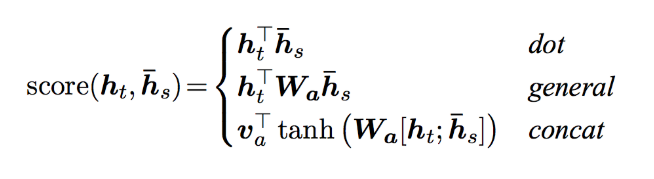

In [20]:
Image(filename='attention_score.jpg')

In [21]:
class AttentionScore(nn.Module):
    def __init__(self, method,hidden_size):
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        
        if self.method=='general':
            self.weights = nn.Linear(self.hidden_size, hidden_size)
        elif self.method=='concat':
            self.weights = nn.Linear(self.hidden_size*2, hidden_size)
    
    # 假设一个encoder的维度是(input_size=10, batch_size=64, hidden_size=500),相当于64个sentence,每个sentence长度位10，500的维度
    # hidden的维度就是（input_size=1, batch_size=64, hidden_size=500),相当于64个sentence,每个sentence长度位10，500的维度
    def dotScore(self, encoder_ouput, hidden):
        # 这里的2相当于将相乘之后的第三个维度，也就是hidden_size进行了一个加和，从500个都加在一起，求了一个和，相当于就是这个单词
        #求一个原来一个句子的权重
        return torch.sum(encoder_ouput*hidden, 2)
    
    def generalScore(self, encoder_ouput, hidden)：
        W_Encoder = self.weights(encoder_ouput)
        return torch.sun(W_Encoder*hidden, 2)
    def concat(self, encoder_ouput,hidden)
        self.weights()
        

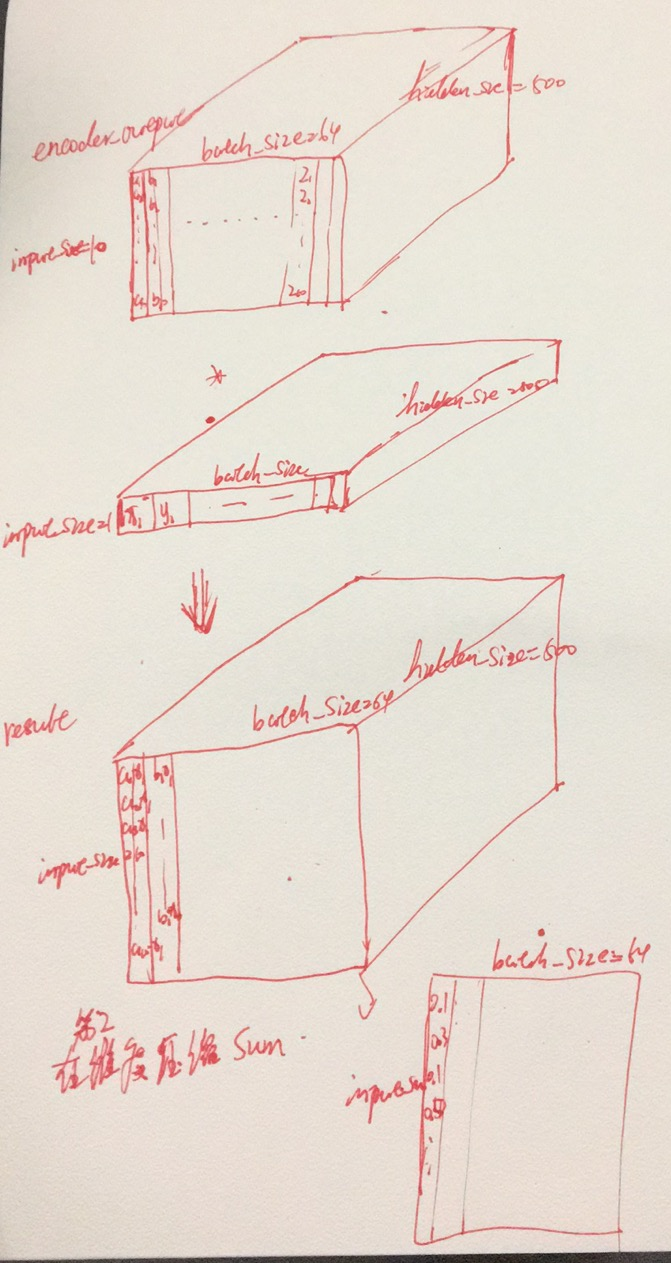

In [67]:
Image(filename='dot_score_process.jpg',width=210, height=100)

In [22]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])


In [45]:
b = torch.arange(6).view(1, 2, 3)
print(b)
print(b.shape)

tensor([[[0, 1, 2],
         [3, 4, 5]]])
torch.Size([1, 2, 3])


In [69]:
b.expand(a.size(0), -1, -1)

tensor([[[0, 1, 2],
         [3, 4, 5]],

        [[0, 1, 2],
         [3, 4, 5]],

        [[0, 1, 2],
         [3, 4, 5]]])

In [55]:
a = torch.arange(18).view(3, 2, 3)
print(a)
print(a.shape)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])
torch.Size([3, 2, 3])


In [61]:
print(b*a)
torch.sum(b*a,2)

tensor([[[ 0,  1,  4],
         [ 9, 16, 25]],

        [[ 0,  7, 16],
         [27, 40, 55]],

        [[ 0, 13, 28],
         [45, 64, 85]]])


tensor([[  5,  50],
        [ 23, 122],
        [ 41, 194]])

In [62]:
print(torch.sum(b*a,2).shape)

torch.Size([3, 2])


In [37]:
c = b * a

In [38]:
c.size()

torch.Size([2, 2, 3])

In [99]:
rnn = nn.GRU(10, 20, 2)

In [102]:
input = torch.randn(5, 3, 10)
input.shape

torch.Size([5, 3, 10])

In [103]:
h0 = torch.randn(2, 3, 20)
h0.shape

torch.Size([2, 3, 20])

In [104]:
output, hn = rnn(input, h0)

In [106]:
output.shape

torch.Size([5, 3, 20])

In [108]:
hn.shape

torch.Size([2, 3, 20])

In [109]:
hn

tensor([[[ 0.0148,  0.1523,  0.0826, -0.2350,  0.1988, -0.0190,  0.4706,
          -0.2935,  0.0530, -0.0324,  0.1790,  0.2754, -0.1924,  0.4073,
           0.0451,  0.5699,  0.1481, -0.2261,  0.3630,  0.1186],
         [ 0.1329, -0.2123,  0.1314,  0.0858, -0.0549, -0.2234,  0.0781,
          -0.1072, -0.0028,  0.3276, -0.0023, -0.1702, -0.0693,  0.2369,
          -0.0377, -0.2264, -0.3863, -0.2516,  0.1492, -0.1128],
         [ 0.0544,  0.1532,  0.3445,  0.1677, -0.0318, -0.1805,  0.1596,
           0.1125, -0.1218,  0.1342,  0.1343,  0.2497, -0.0696,  0.2703,
           0.1290,  0.2676,  0.1492,  0.1053,  0.0785,  0.4557]],

        [[-0.1173, -0.0267, -0.2650, -0.1826, -0.2882, -0.1207, -0.1583,
          -0.1609, -0.0770, -0.0964, -0.1968,  0.0574, -0.1364, -0.0972,
          -0.1907,  0.0712,  0.2190,  0.0903,  0.2655,  0.1311],
         [ 0.0636, -0.1662, -0.3389, -0.2263, -0.7335, -0.0973, -0.0964,
          -0.3771,  0.0871, -0.0704, -0.4565,  0.1621, -0.1413, -0.1975,
        

In [113]:
from torch.nn.utils.rnn import pack_sequence
a = torch.tensor([1,2,3])
b = torch.tensor([4,5])
c = torch.tensor([6])
lens = torch.tensor([3,2,1])
packed = pack_padded_sequence([a, b, c],lens)
packed

TypeError: _pack_padded_sequence(): argument 'input' (position 1) must be Tensor, not list

In [ ]:
pack_padded_sequence

In [87]:
y = [['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .']]

sorted(y, key=lambda x: len(x[0].split()),reverse=True)

[['you have my word . as a gentleman', 'you re sweet .'],
 ['well no . . .', 'then that s all you had to say .'],
 ['have fun tonight ?', 'tons'],
 ['there .', 'where ?'],
 ['hi .', 'looks like things worked out tonight huh ?']]